In [120]:
import seaborn as sns
import pandas as pd
import numpy as np
import sys,os

from scipy.stats import zscore

from matplotlib import cm
from matplotlib import pyplot as plt
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

In [121]:
RUN_PATH = "/NVME/decrypted/scratch/multitrait/UK_BIOBANK_ZERO/"
PHENO_PATH = RUN_PATH+"participant_phenotype/"
ID = "2022_07_08_ventile5"
usedtraits = []

# RUN_PATH = sys.argv[1]
# PHENO_PATH = RUN_PATH+"participant_phenotype/"
# ID = sys.argv[2]
# usedtraits = sys.argv[3]

traitsfile = PHENO_PATH+ID+'_corrected_z.csv'
ldscfile = RUN_PATH+"gwas/"+ID+"__FINAL/all_h2.csv"
coxfile = RUN_PATH+"diseases_cov/"+ID+"__cox_pval.csv"

outfile1=RUN_PATH+"participant_phenotype/"+ID+"__corr_h2_disease_1.pdf"
outfile2=RUN_PATH+"participant_phenotype/"+ID+"__corr_h2_disease_2.pdf"

In [122]:
traits=pd.read_csv(traitsfile, index_col=0)
ldsc=pd.read_csv(ldscfile, index_col=0)
cox=pd.read_csv(coxfile, index_col=0)
cox = -cox.apply(np.log)
cox = cox.loc[sorted(cox.index)]

Index(['AVScore_all', 'AVScore_artery', 'AVScore_longestFifth_all',
       'AVScore_longestFifth_artery', 'AVScore_longestFifth_vein',
       'AVScore_vein', 'DF_all', 'DF_artery', 'DF_longestFifth_all',
       'DF_longestFifth_artery',
       ...
       'tau6_longestFifth_all', 'tau6_longestFifth_artery',
       'tau6_longestFifth_vein', 'tau6_vein', 'tau7_all', 'tau7_artery',
       'tau7_longestFifth_all', 'tau7_longestFifth_artery',
       'tau7_longestFifth_vein', 'tau7_vein'],
      dtype='object', length=122)


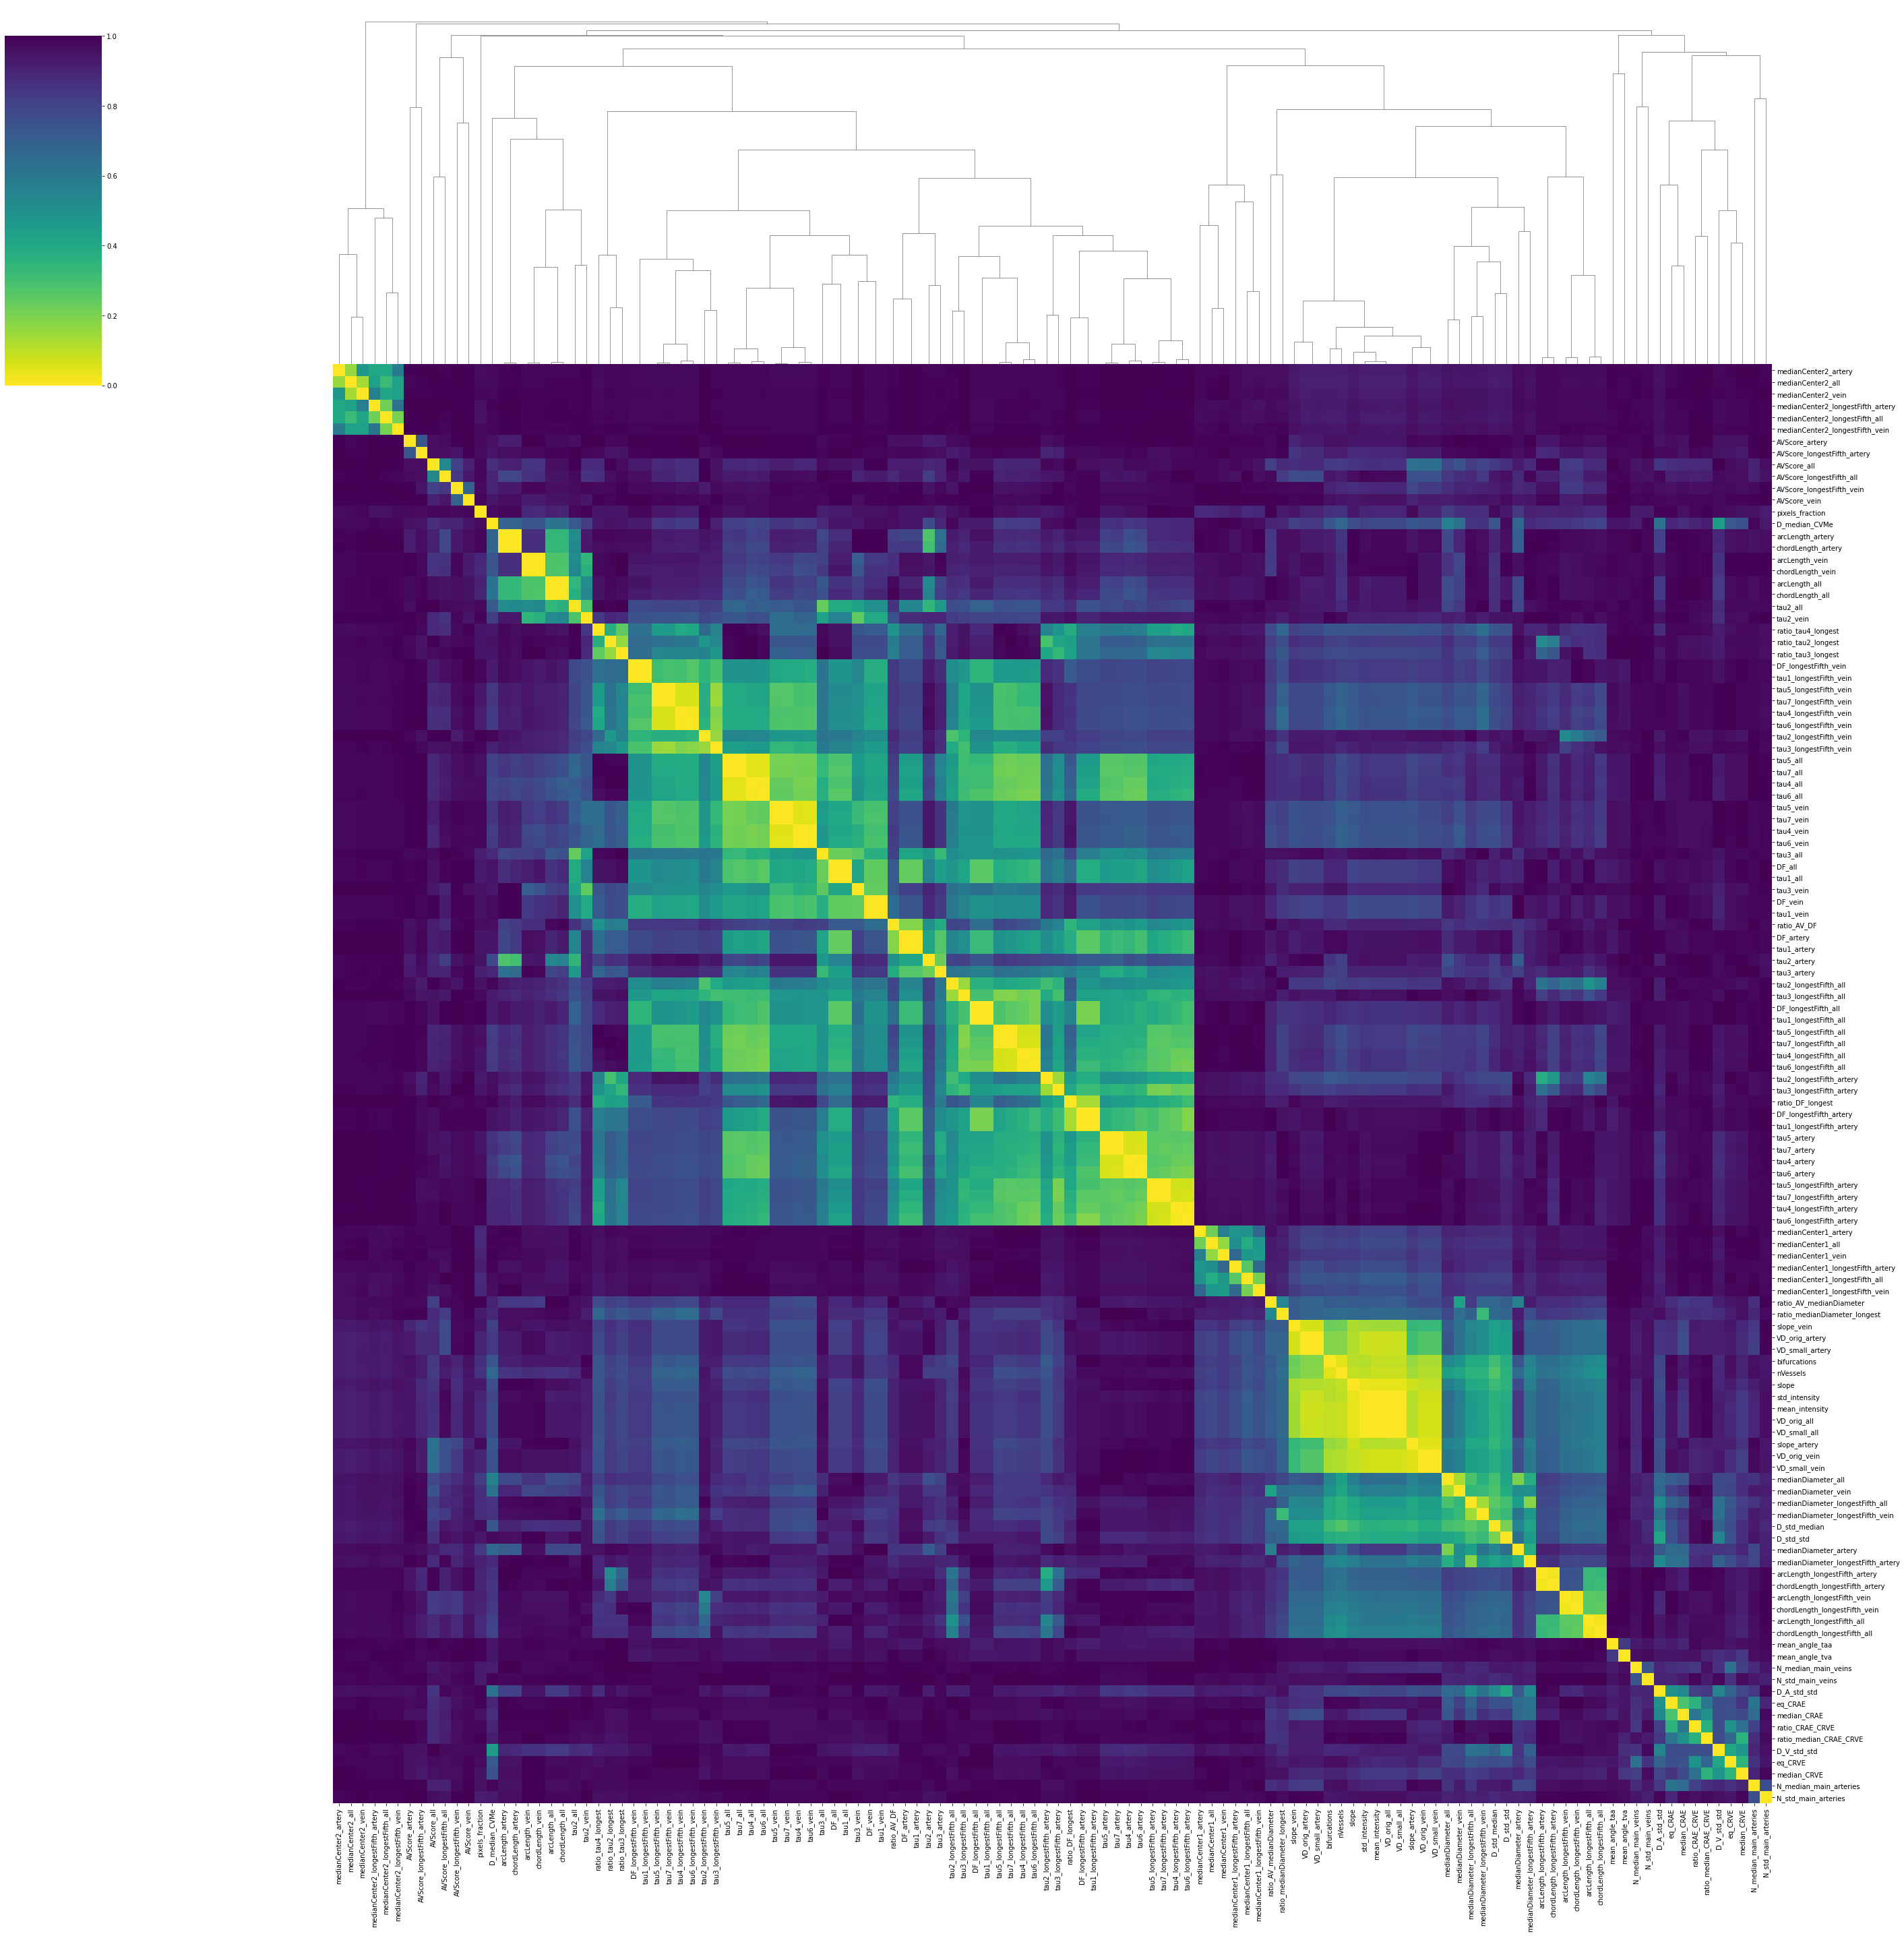

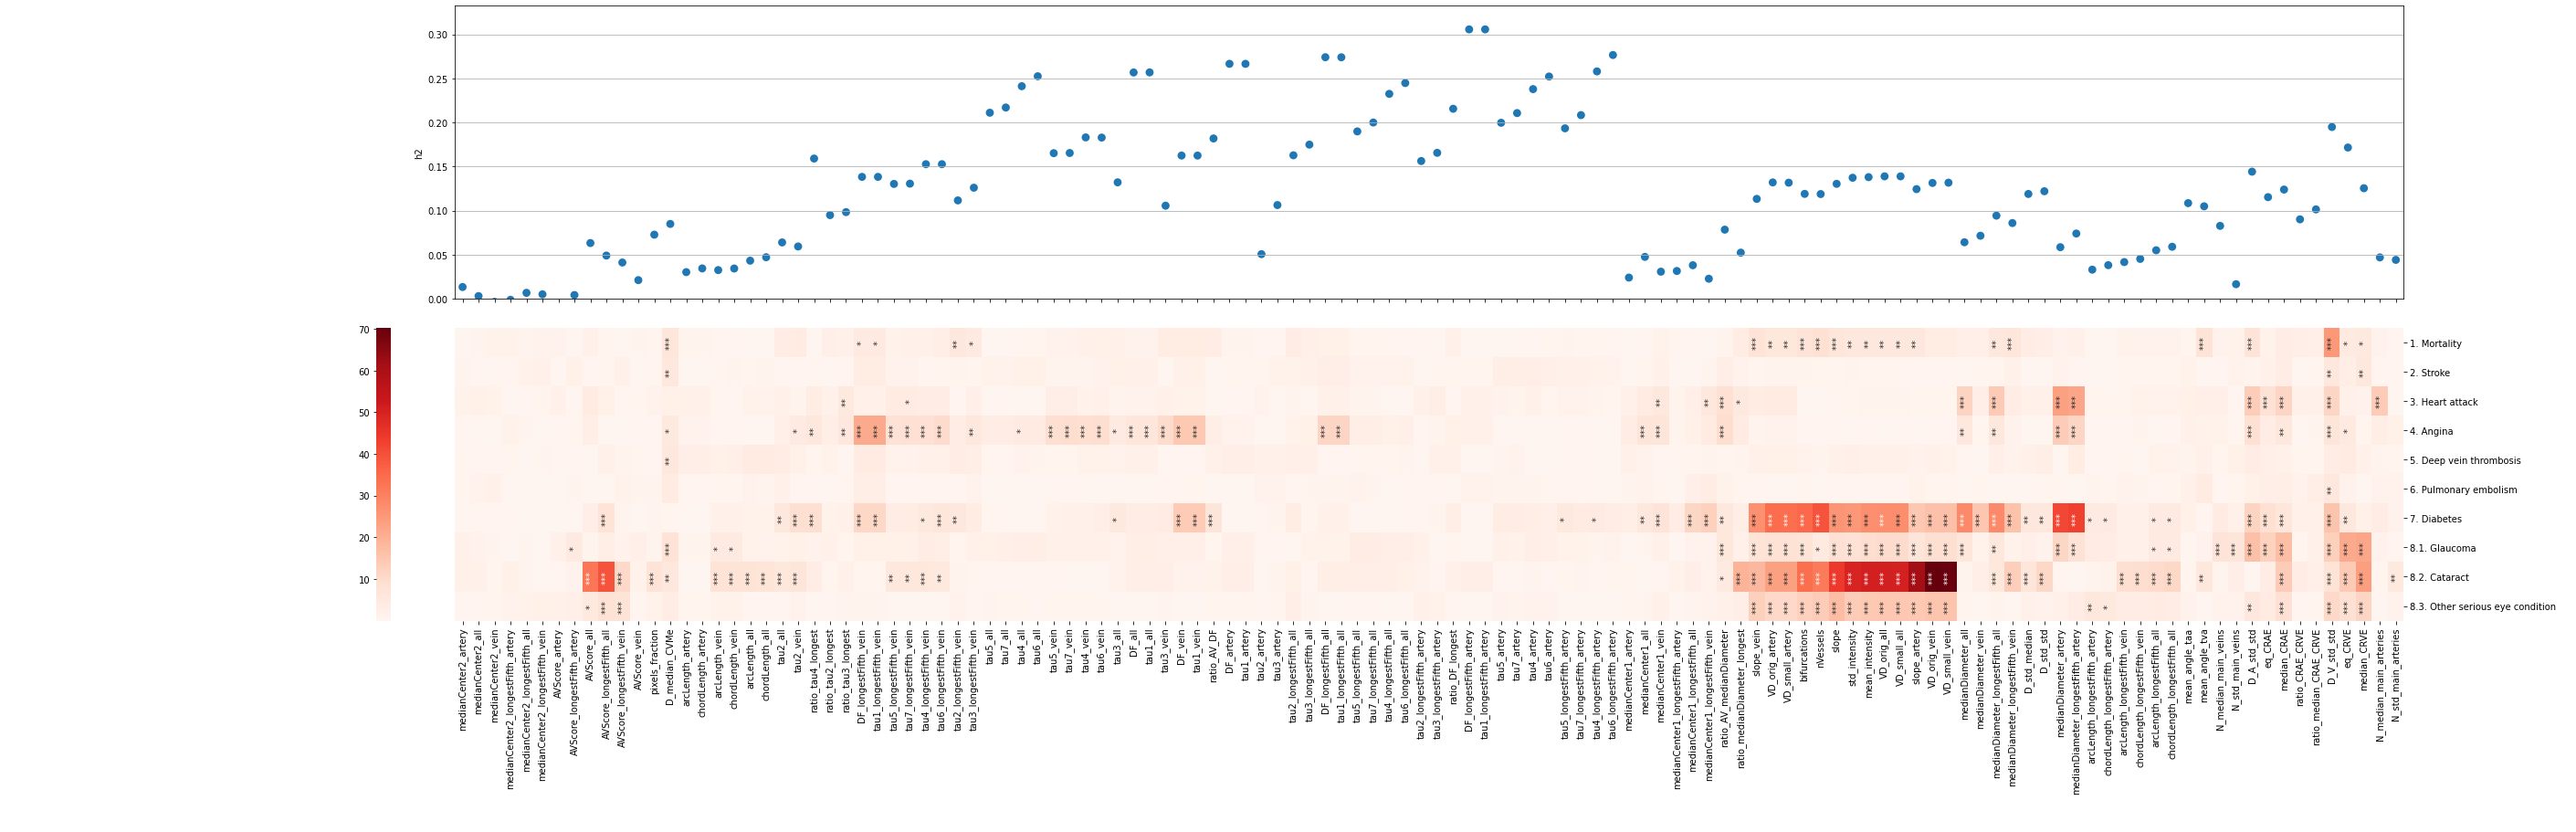

In [126]:
# A: Clustermap

import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris

# traits['FUN'] = -traits['VD_orig_all']
usedtraits=[i for i in traits.columns if ((('tau' in i) | ('DF' in i)) & ('longest' in i))]
usedtraits=traits.columns#cluster_traits
print(usedtraits)

DF_corr = traits[usedtraits].corr()
DF_dism = 1 - abs(DF_corr)   # pairwise distance: I define distance between two perfectly negatively correlated traits as 0

# pairwise distance metric: an easy proxy for "correlation distance": 1 - abs(corr)
# clustering method: average

linkage = hc.linkage(sp.distance.squareform(DF_dism), method='average')

# print cophenetic distance
hc.cophenet(linkage, sp.distance.squareform(DF_dism))

h = sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage, cmap=cm.get_cmap('viridis_r'), figsize=(40,40), vmin=0, vmax=1)
h.ax_row_dendrogram.set_visible(False)
#h.ax_heatmap.xaxis.tick_top()
h.ax_heatmap.tick_params(axis='x', rotation=90)

plt.savefig(outfile1)

# B: Heritability
# C: Disease & mortality

# reorder ldsc and cox according to phenotypic clustering
ldsc = ldsc.loc[traits[usedtraits].columns[h.dendrogram_row.reordered_ind]]
cox = cox[traits[usedtraits].columns[h.dendrogram_row.reordered_ind]]

#### B: HERITABILITY

fig, axs = plt.subplots(nrows=3, figsize=(40,13), gridspec_kw={'height_ratios': [50, 50, 30]})

h_h2=sns.pointplot(data=ldsc,x=ldsc.index, y='h2',ax=axs[0],join=False)
axs[0].grid(axis='y')
axs[0].set_ylim((0,max(0.3,max(ldsc['h2']+max(ldsc['h2_se'])))))
h_h2.set(xticklabels=[])

plt.tight_layout() # needed to match x-axis later

#### C: DISEASE

# Cox significance asterisks

significant = cox > -np.log10(0.05 / cox.shape[0] / cox.shape[1])

asterisks = significant.applymap(str)
asterisks = asterisks.replace('False', "")
asterisks = asterisks.replace('True', "*")

significant = cox > -np.log10(0.01 / cox.shape[0] / cox.shape[1])
tmp = significant.applymap(str)
tmp = tmp.replace('False', "")
tmp = tmp.replace('True', "**")
asterisks[significant] = tmp[significant]

significant = cox > -np.log10(0.001 / cox.shape[0] / cox.shape[1])
tmp = significant.applymap(str)
tmp = tmp.replace('False', "")
tmp = tmp.replace('True', "***")
asterisks[significant] = tmp[significant]

# plot cox heatmap

h_cox=sns.heatmap(data=cox, ax=axs[1], annot=asterisks, fmt='', annot_kws={'rotation': 90}, cbar_kws={'location':'left'}, cmap='Reds')
axs[1].tick_params(axis='y', rotation=0)
axs[1].yaxis.tick_right()


# plt.tight_layout() # needed to match x-axis later


# adjust plot position on X to match cluster

# originals
pos=axs[0].get_position().get_points()
pos_cluster=h.ax_heatmap.get_position().get_points()

# adapt to cluster
pos[0][0] = pos_cluster[0][0]
pos[1][0] = pos_cluster[1][0]

# create adjusted bbox object
bbox=axs[0].get_position()
bbox.set_points(pos)

# adapt plot
axs[0].set_position(bbox)


pos=h_cox.get_position().get_points()
pos[0][0] = pos_cluster[0][0]
pos[1][0] = pos_cluster[1][0]
bbox=h_cox.get_position()
bbox.set_points(pos)
axs[1].set_position(bbox)

axs[2].axis('off')
plt.savefig(outfile2)